In [260]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

In [261]:
imdb_path = r'C:\Users\espym.LAPTOP-41F90NSA\Desktop\zippedData\im.db\im.db'
conn = sqlite3.connect(imdb_path)


In [262]:
file_path1 = r'C:\Users\espym.LAPTOP-41F90NSA\projects\Movie_Project-1\tmdb.movies.csv.gz'
tmdbDF = pd.read_csv(file_path1)

In [263]:
filepath2 = r'C:\Users\espym.LAPTOP-41F90NSA\projects\Movie_Project-1\tn.movie_budgets.csv.gz'
tn_movieDF = pd.read_csv(filepath2)

In [264]:
filepath3 = r'C:\Users\espym.LAPTOP-41F90NSA\projects\Movie_Project-1\rt.movie_info.tsv.gz'
movie_infoDF = pd.read_csv(filepath3, delimiter='\t')

In [265]:
filepath4 =r'C:\Users\espym.LAPTOP-41F90NSA\projects\Movie_Project-1\rt.reviews.tsv.gz'
reviewsDF = pd.read_csv(filepath4, delimiter='\t', encoding='latin-1')

## Preview of Information in the data

Here we just want to have a look at whats contained in the IMDB dataset and just have a proper feel of whats contained in the dataset

In [266]:
#from the imdb database we first want to know the names and number of the tables.
query0 = ("""
    SELECT name
    AS 'Table_Name'
    FROM sqlite_master
    WHERE type = 'table'
;
""")
pd.read_sql(query0,conn)

,Table_Name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [267]:
# checking for the information contained in the movie basics table
query1 = ("""
    SELECT * 
    FROM movie_basics
    ;
          """)
pd.read_sql(query1,conn).head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [268]:
# In the reviews dataframe we will check for the last values
pd.read_sql(query1,conn).tail()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None
146143,tt9916754,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,2013,NaN,Documentary


In [269]:
#check the shape of the dataframe 
pd.read_sql(query1,conn).shape

(146144, 6)

In [270]:
#check for all the columns in the DF
pd.read_sql(query1,conn).columns

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres'],
      dtype='object')

In [271]:
pd.read_sql(query1,conn).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [272]:
pd.read_sql(query1,conn).describe()

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


In [273]:
# Checking for the unique genres
df = pd.read_sql(query1,conn)
genre_column = df['genres']
df['genres'].unique()

array(['Action,Crime,Drama', 'Biography,Drama', 'Drama', ...,
       'Music,Musical,Reality-TV', 'Animation,Crime',
       'Adventure,History,War'], dtype=object)

Now that we have a feel of the movie_basics, well also explore movie_ratings table

In [274]:
query2 = ("""
    SELECT * 
    FROM movie_ratings
    ;
        """)
pd.read_sql(query2,conn).head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [275]:
pd.read_sql(query2,conn).tail()

,movie_id,averagerating,numvotes
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5
73855,tt9894098,6.3,128


In [276]:
pd.read_sql(query2,conn).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [277]:
pd.read_sql(query2,conn).describe()

,averagerating,numvotes
count,73856.000000,7.385600e+04
mean,6.332729,3.523662e+03
std,1.474978,3.029402e+04
min,1.000000,5.000000e+00
25%,5.500000,1.400000e+01
50%,6.500000,4.900000e+01
75%,7.400000,2.820000e+02
max,10.000000,1.841066e+06


In [278]:
# previwing the third dataset Movie budgets
tn_movieDF.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [279]:
tn_movieDF.tail()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0
5781,82,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041"


In [280]:
tn_movieDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [281]:
tn_movieDF.count()

id                   5782
release_date         5782
movie                5782
production_budget    5782
domestic_gross       5782
worldwide_gross      5782
dtype: int64

## Data Cleaning

Now that we have a feeling of the data, we will now combine the two tables i.e movie_basics and movie_ratings using their primary key movie_id

In [282]:
#Joining the tables using the movie_id column
query3 = ("""
SELECT movie_id, primary_title,start_year,runtime_minutes,genres,averagerating AS 'movie_rating'
FROM movie_basics
JOIN movie_ratings
USING (movie_id)
;
""")
df = pd.read_sql(query3,conn)

In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   start_year       73856 non-null  int64  
 3   runtime_minutes  66236 non-null  float64
 4   genres           73052 non-null  object 
 5   movie_rating     73856 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 3.4+ MB


We will now go ahead and clean the dataset to remove the missing values in the dataframe. The columns runtime_minutes and genres appear to having missing values

In [284]:
df.isnull().sum()

movie_id              0
primary_title         0
start_year            0
runtime_minutes    7620
genres              804
movie_rating          0
dtype: int64

In [285]:
#checking for the percentage of missing values in the dataframe
#checking for the sum of null values
null_count = df.isnull().sum()


In [286]:
#checking for all the values
non_null_count = df.shape[0]

In [287]:
#checking the percentage of the null values to determine if to drop them
null_percentage = (null_count / non_null_count) * 100
print(null_percentage)

movie_id            0.000000
primary_title       0.000000
start_year          0.000000
runtime_minutes    10.317374
genres              1.088605
movie_rating        0.000000
dtype: float64


In [288]:
#The null values take a minimal percentage of the total values and can be droppped
df.dropna(inplace=True)
df.shape

(65720, 6)

In [289]:
#checking null values in the other dataframe
budgetDF = tn_movieDF
budgetDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


The budget dataframe contains no null values

Conversion of datatypes

In [290]:
budgetDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [291]:
#The prodution_budget,domestic_gross and worldwide_gross are denoted as objects and we need them as float in order to mathematical computations
budgetDF['production_budget'] = budgetDF['production_budget'].str.replace('$', '').str.replace(',', '').astype(float)
budgetDF['domestic_gross'] = budgetDF['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(float)
budgetDF['worldwide_gross'] = budgetDF['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)

Checking for duplicates 


In [292]:
df.duplicated().sum()

0

In [293]:
budgetDF.duplicated().sum()

0

From both the datasets, there are no duplicated values

Checking for data consistency

In [294]:
df.describe()

,start_year,runtime_minutes,movie_rating
count,65720.000000,65720.000000,65720.000000
mean,2014.258065,94.732273,6.320902
std,2.600143,209.377017,1.458878
min,2010.000000,3.000000,1.000000
25%,2012.000000,81.000000,5.500000
50%,2014.000000,91.000000,6.500000
75%,2016.000000,104.000000,7.300000
max,2019.000000,51420.000000,10.000000


From this we have a few issues in regards to runtime
1. The minimum runtime is 3 minutes which is quite low to meet a movie threshold
2. The maximum runtime is 51420 which an extreme value

filtering the values to include a minimum threshold of 20 minutes and 180 minutes 

In [295]:
clean_runtime = df[(df['runtime_minutes'] >= 20) & (df['runtime_minutes'] <= 180)]
sum_of_movies_within_threshold = len(clean_runtime)
print('The movies within the threshold are:', sum_of_movies_within_threshold)

The movies within the threshold are: 65365


In [296]:
df = df[(df['runtime_minutes'] >= 20) & (df['runtime_minutes'] <= 200)]

In [297]:
df.describe()

,start_year,runtime_minutes,movie_rating
count,65449.000000,65449.000000,65449.000000
mean,2014.256337,93.393176,6.316784
std,2.599812,21.768529,1.457446
min,2010.000000,20.000000,1.000000
25%,2012.000000,81.000000,5.500000
50%,2014.000000,91.000000,6.500000
75%,2016.000000,104.000000,7.300000
max,2019.000000,200.000000,10.000000


In [298]:
budgetDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   float64
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 271.2+ KB


We have an issue with the release date as its an object and its needed to be in date format

In [299]:
#conversion of release date from object to datetime
budgetDF['release_date'] = pd.to_datetime(budgetDF['release_date'])

In [300]:
budgetDF.describe()

,id,production_budget,domestic_gross,worldwide_gross
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09


From this we also have the issue of domestic gross and worldwide gross are zero 

In [301]:
#checking for the duration of info in the budget dataframe
start_date = budgetDF['release_date'].min()
end_date = budgetDF['release_date'].max()

print(f'the start date is {start_date} and the end date is {end_date}')


the start date is 1915-02-08 00:00:00 and the end date is 2020-12-31 00:00:00


From this we see the first date is 1915 which is significantly a long time ago and the film and production industry has changed in one way or another. We will now convert the dataframe to start in the the year 2000 and end in 2019 as 2020 has no gross earnings

In [302]:
start_date = pd.to_datetime('2000-1-1 00:00:00')
end_date = pd.to_datetime('2019-12-31 00:00:00')
budgetDF = budgetDF[(budgetDF['release_date'] >= start_date) & (budgetDF['release_date'] <= end_date)]

## Explarotary Analysis

In [303]:
#checking for the year and duration of the release dates 
start_date = df['start_year'].min()
end_date = df['start_year'].max()
period_taken = end_date - start_date

print('start:', start_date)
print('stop:', end_date)
print('durarion:', period_taken,'years')

start: 2010
stop: 2019
durarion: 9 years


In [304]:
#checking for the duration of info in the budget dataframe
start_date = budgetDF['release_date'].min()
end_date = budgetDF['release_date'].max()
period_taken = end_date -  start_date

print('The start date is', start_date)
print('The end date id', end_date)
print('Period of the dataset is', period_taken)

The start date is 2000-01-12 00:00:00
The end date id 2019-12-31 00:00:00
Period of the dataset is 7293 days 00:00:00


Univariate Analysis

In [305]:
df.columns

Index(['movie_id', 'primary_title', 'start_year', 'runtime_minutes', 'genres',
       'movie_rating'],
      dtype='object')

In [306]:
df['primary_title'].describe()

count          65449
unique         62195
top       The Return
freq              10
Name: primary_title, dtype: object

In [307]:
#Checking for the most common genre
df['genres'].describe()


count     65449
unique      905
top       Drama
freq      10160
Name: genres, dtype: object

In [308]:
df['genres'].value_counts()

Drama                           10160
Documentary                      9031
Comedy                           4601
Comedy,Drama                     2449
Horror                           2230
                                ...  
Crime,Documentary,Fantasy           1
Sport,Thriller                      1
Documentary,Family,Sci-Fi           1
Adventure,Documentary,Sci-Fi        1
Adventure,Romance,Sport             1
Name: genres, Length: 905, dtype: int64

In [309]:
budgetDF.columns

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')

In [310]:
budgetDF['movie'].describe()

count     4384
unique    4361
top       Home
freq         3
Name: movie, dtype: object

Bivariate Analysis

How has the average movie runtime changed over the years

In [311]:
df.columns

Index(['movie_id', 'primary_title', 'start_year', 'runtime_minutes', 'genres',
       'movie_rating'],
      dtype='object')

In [312]:
runtime_changes_over_years = df.groupby('start_year')['runtime_minutes'].mean()
print(runtime_changes_over_years)

start_year
2010    92.084137
2011    91.889349
2012    91.508410
2013    92.235916
2014    93.131877
2015    93.167301
2016    93.576630
2017    94.554109
2018    96.542604
2019    99.883565
Name: runtime_minutes, dtype: float64


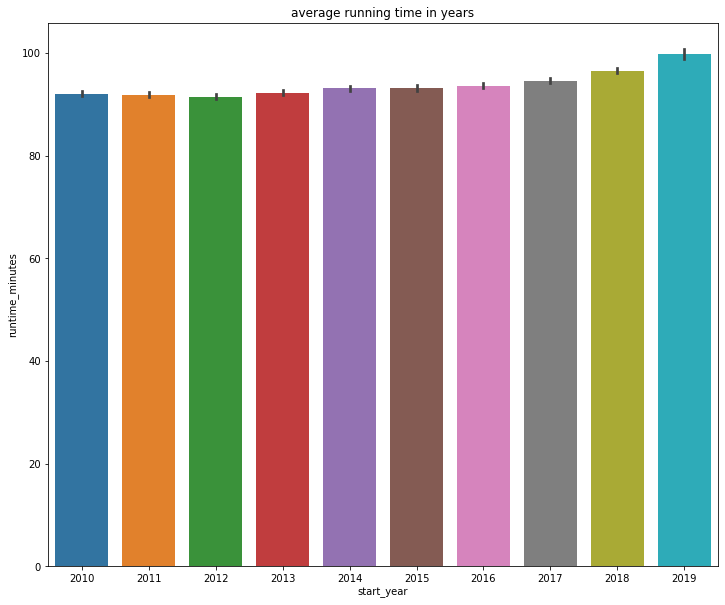

In [313]:
#To visualize the average runtime through the years
plt.figure(figsize=(12,10))
sns.barplot(x='start_year', y='runtime_minutes', data=df)
plt.title('average running time in years')
plt.show()

Analyzing the relationship between Genres and Runtime

In [314]:
df.columns

Index(['movie_id', 'primary_title', 'start_year', 'runtime_minutes', 'genres',
       'movie_rating'],
      dtype='object')

In [315]:
#Checking for the the first 10 movies with the highest runtimes and their genres
top_10_runtime = df.nlargest(10,'runtime_minutes')[['primary_title','runtime_minutes','genres']].set_index('primary_title')
top_10_runtime

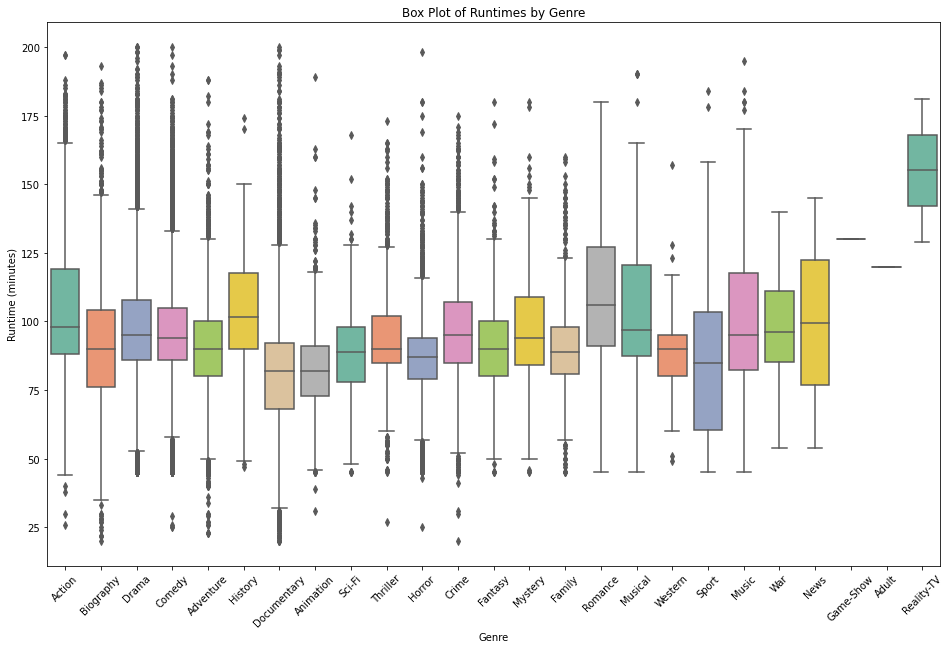

In [317]:
#To visualize the relationship between genres and their runtime
plt.figure(figsize=(16,10))
df['genre'] = df['genres'].str.split(',').str[0].str.strip()
sns.boxplot(data=df, x='genre', y='runtime_minutes', palette='Set2')
plt.xlabel('Genre')
plt.ylabel('Runtime (minutes)')
plt.title('Box Plot of Runtimes by Genre')
plt.xticks(rotation=45)
plt.show()


What is the average movie rating over the years

In [318]:
df.columns

Index(['movie_id', 'primary_title', 'start_year', 'runtime_minutes', 'genres',
       'movie_rating', 'genre'],
      dtype='object')

In [319]:
average_ratings_over_years = df.groupby('start_year')['movie_rating'].mean().sort_values()
print(average_ratings_over_years)

start_year
2010    6.262155
2015    6.262302
2011    6.287418
2013    6.289693
2012    6.289732
2014    6.319249
2016    6.321136
2017    6.357507
2018    6.370460
2019    6.650641
Name: movie_rating, dtype: float64


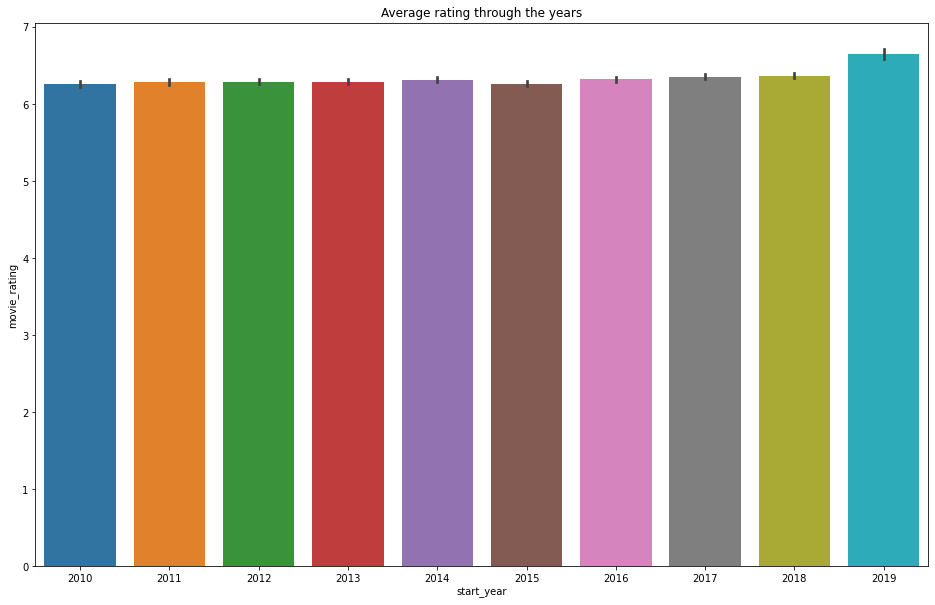

In [320]:
plt.figure(figsize=(16,10))
sns.barplot(x='start_year',y='movie_rating',data=df)
plt.title('Average rating through the years')
plt.show()

Checking for the relationship between average ratings and genres

In [332]:
#Checking for the the first 10 movies with the highest runtimes and their genres
top_10_ratings = df.nlargest(10,'movie_rating')[['primary_title','movie_rating','genres']].set_index('primary_title')
top_10_ratings

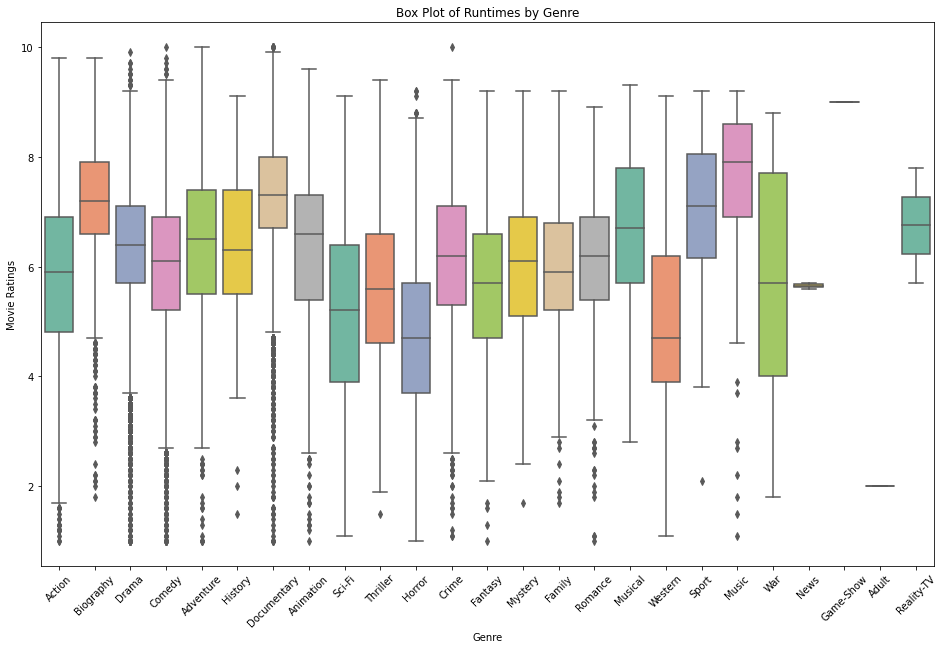

In [334]:
#To visualize the relationship between genres and their ratings
plt.figure(figsize=(16,10))
df['genre'] = df['genres'].str.split(',').str[0].str.strip()
sns.boxplot(data=df, x='genre', y='movie_rating', palette='Set2')
plt.xlabel('Genre')
plt.ylabel('Movie Ratings')
plt.title('Box Plot of Runtimes by Genre')
plt.xticks(rotation=45)
plt.show()

In [335]:
budgetDF.columns

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')

The release date is inclusive of date and month and for this we just want the years. We will convert the release date to years only

In [322]:
#conversion to years
budgetDF['release_date'] = budgetDF['release_date'].dt.year

<ipython-input-322-13c939025b43>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  budgetDF['release_date'] = budgetDF['release_date'].dt.year


Checking for the year with the highest average gross earnings

In [323]:
average_earnings = budgetDF.groupby('release_date')['worldwide_gross'].mean().sort_values(ascending=False)
print(average_earnings)

release_date
2018    1.824786e+08
2017    1.692240e+08
2016    1.313614e+08
2012    1.156729e+08
2013    1.107553e+08
2009    1.003943e+08
2019    9.965411e+07
2014    9.911344e+07
2011    9.714671e+07
2004    8.924908e+07
2010    8.843764e+07
2007    8.641767e+07
2015    8.225145e+07
2003    8.209727e+07
2008    8.155407e+07
2001    8.096845e+07
2005    7.888583e+07
2002    7.822510e+07
2006    7.163864e+07
2000    6.891062e+07
Name: worldwide_gross, dtype: float64


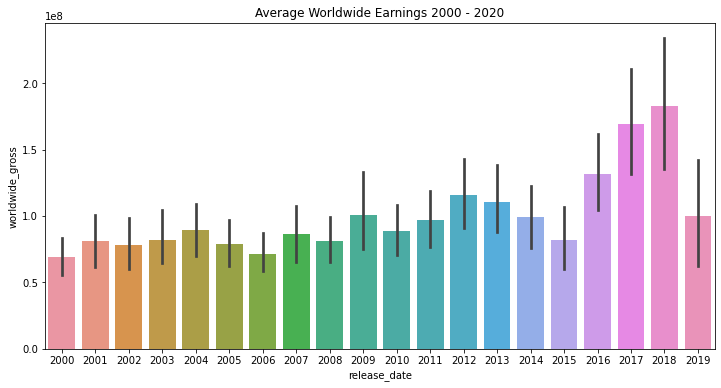

In [324]:
plt.figure(figsize=(12,6))
sns.barplot(x='release_date', y='worldwide_gross',data=budgetDF)
plt.title('Average Worldwide Earnings 2000 - 2020')
plt.show()

Does Running Time affect rating

In [325]:
df.columns

Index(['movie_id', 'primary_title', 'start_year', 'runtime_minutes', 'genres',
       'movie_rating', 'genre'],
      dtype='object')

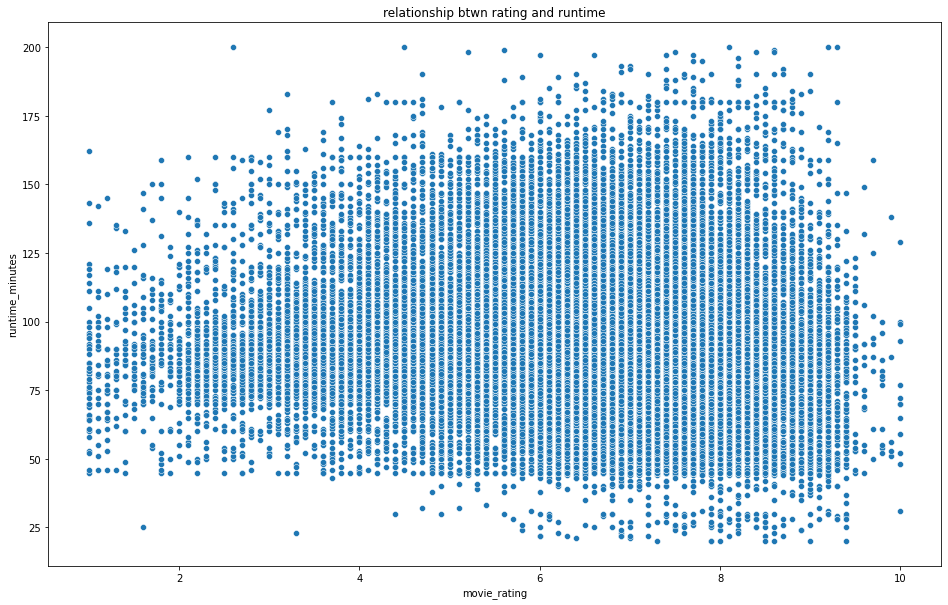

In [326]:
plt.figure(figsize=(16,10))
sns.scatterplot(x='movie_rating',y='runtime_minutes',data=df)
plt.title('relationship btwn rating and runtime')
plt.show()

FInding theres a relationship between budget and worldwide income

In [327]:
budgetDF.columns

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')

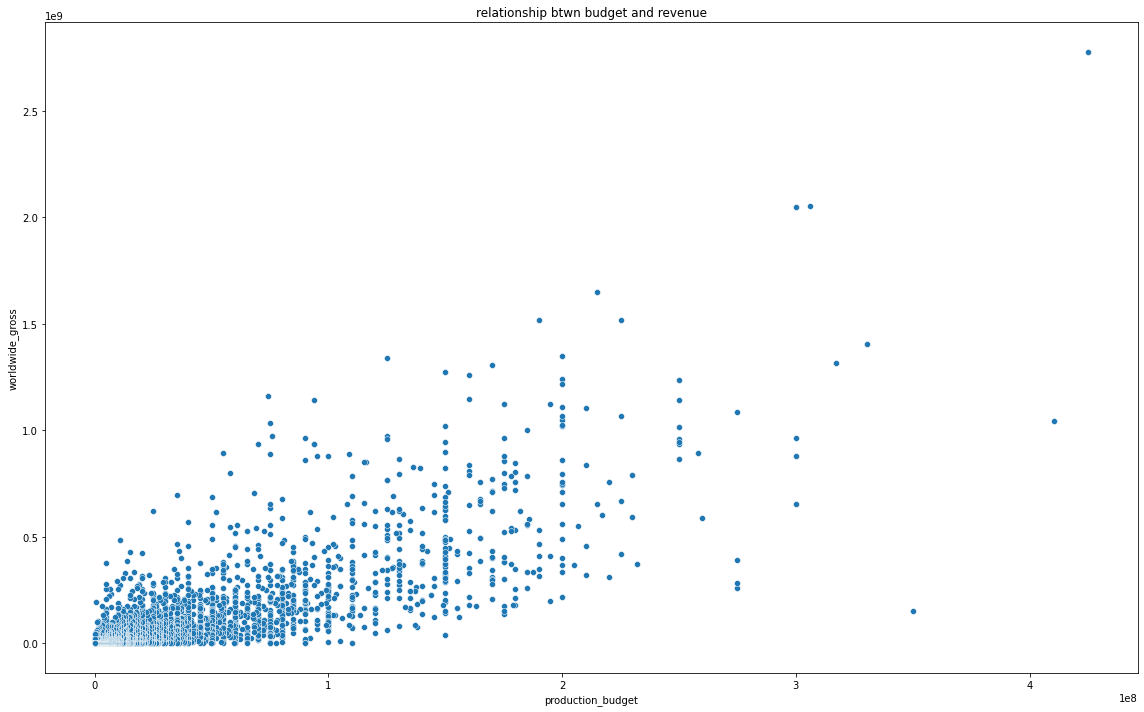

In [328]:
plt.figure(figsize=(16,10))
sns.scatterplot(x='production_budget', y='worldwide_gross', data=budgetDF)
plt.title('relationship btwn budget and revenue')
plt.tight_layout()
plt.show()
